# Final project

### PREPARATION PART BEGINS

This final project is done by **Herman Havva**

### PREPARATION PART ENDS

-----------------------------

Install libraries:


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [23]:
!pip uninstall altair -y

Found existing installation: altair 6.0.0
Uninstalling altair-6.0.0:
  Successfully uninstalled altair-6.0.0


## Cool project, awesome project
### The roadmap of the project 
1. Clean-up and arranging of the data
2. **Analysis**

#### Analysis layout (what it attempts to show)
- **Main objective:** to create a comprehensive analysis of the extensive guide, explore the following points of interest
    1. Which districts(повіти) appear to be more wealthy in comparison to others, as in Russian Empire merchanants(wealthy prople) could leave some **treasures**(скарби) for "good times", we want to explore that
    2. Also, by any chance, lets explore the ratio of men and women born and dead, may be we can find something interesting, lets find it per district. Apart from the fact that there were several cholera outbreaks, I could not find any interesting catastrophes on the teritory of interest. 
    3. 
    
    (possibility) on the 10 tab compare the christians number to jews number (bar chart, x-axis is cities, two bars for each city), in total 2 bar charts for each revision
    (possibility) we can make a demographic chart by the 13_відтворення_населення_роки
    (possibility) we could extract the total population from the 2_Народонаселення_1848р and make a demographhic chart for 2 years


#### Clean-up and arranging the data 
- renamed the dataframes (.csv) to have reasonable names
- extracted raw data into pandas dataframes for the future analysis

In [3]:
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import altair as alt

In [4]:

total_reproduction_df = pd.read_csv('./data/13_відтворення_населення_роки.csv', 
                 header=[0, 1], 
                 encoding='utf-8', 
                 sep=',')         

top_level = total_reproduction_df.columns.get_level_values(0).to_series()

clean_top_level = top_level.replace(r'^Unnamed:.*', np.nan, regex=True).ffill()
total_reproduction_df.columns = pd.MultiIndex.from_arrays([clean_top_level, total_reproduction_df.columns.get_level_values(1)])

years_column = total_reproduction_df.iloc[:, 0] 

# add year index
total_reproduction_df.index = years_column
total_reproduction_df.index.name = 'Рік'

# remove old year column
total_reproduction_df = total_reproduction_df.iloc[:, 1:]

total_reproduction_df.index = pd.to_numeric(total_reproduction_df.index.to_series(), errors='coerce')


if total_reproduction_df.index.dtype == 'float64':
    total_reproduction_df.index = total_reproduction_df.index.astype('Int64')

total_reproduction_df = total_reproduction_df[total_reproduction_df.index.notna()]

total_reproduction_df.columns.names = ['Повіт', 'Стать']

print(total_reproduction_df['Губернія загалом'])  # here it gives me one NA because of the 'Разом' field

Стать        ч        ж     о.с.
Рік                             
1835    2459.0    282.0   2741.0
1836   11565.0  10271.0  21836.0
1837   10940.0   9259.0  20199.0
1838    6975.0   5280.0  12255.0
1839   14550.0  11621.0  26171.0
1840    3260.0   2377.0   5637.0
1841   10514.0   9422.0  19936.0
1842   -3500.0  -5478.0  -8978.0
1843   20600.0  18352.0  38952.0
1844   17459.0  15702.0  33161.0
1845    9258.0   9014.0  18272.0
1846    1091.0   9346.0  10437.0
1847   14076.0  13221.0  27297.0
1848  -16767.0 -20611.0 -37378.0
1849     935.0  -1318.0   -383.0
1850   11668.0  10959.0  22627.0


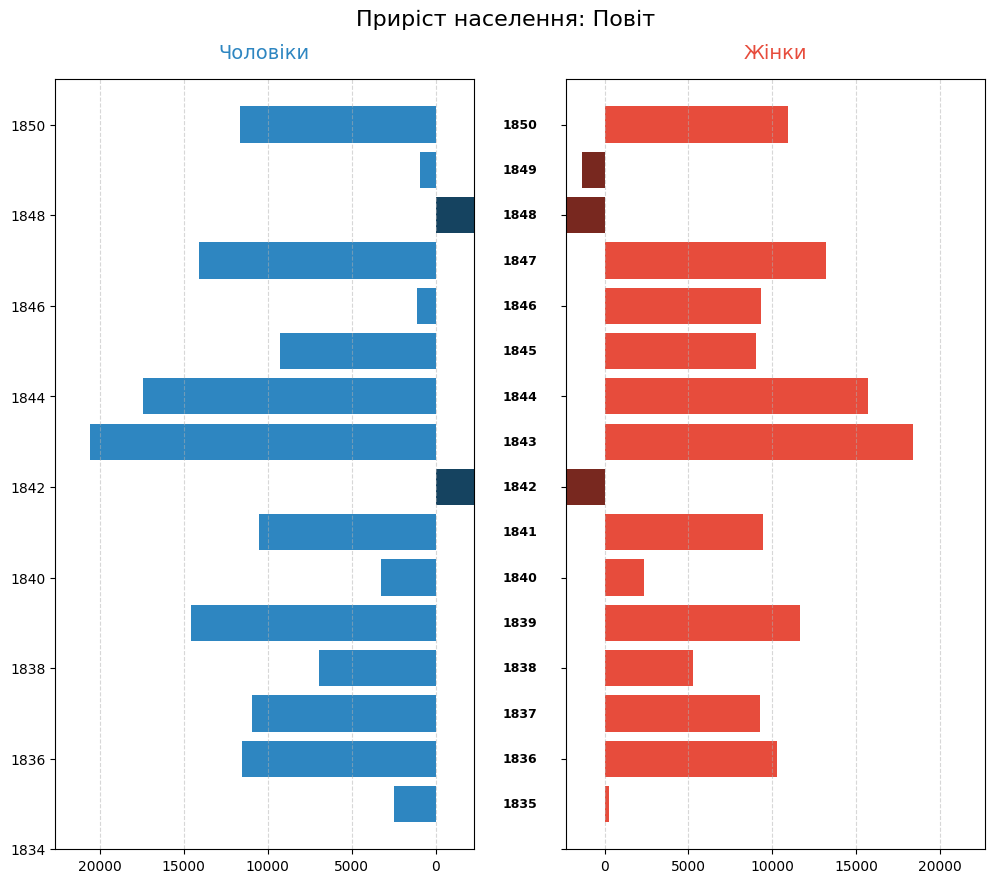

In [67]:


# Припускаємо, що total_reproduction_df вже створений вашим кодом вище
# Але для безпеки конвертуємо дані у звичайні float (matplotlib краще працює з numpy масивами, ніж з Int64)
df_plot = total_reproduction_df['Губернія загалом'].astype(float)
years = total_reproduction_df.index.values

# Отримуємо дані. 
# Замінюємо NaN на 0, щоб графік не зламався
males = df_plot['ч'].fillna(0).values
females = df_plot['ж'].fillna(0).values

# --- Налаштування візуалізації ---

# Створюємо фігуру з 3 частин: (Чоловіки) (Текст років) (Жінки)
# width_ratios=[1, 0.2, 1] робить середню колонку вузькою
fig, axes = plt.subplots(ncols=3, sharey=True, figsize=(12, 10), 
                         gridspec_kw={'width_ratios': [1, 0.15, 1], 'wspace': 0.05})
ax_male, ax_year, ax_female = axes

# --- 1. Графік для Чоловіків (Ліва частина) ---
# Використовуємо різні кольори для приросту (синій) та спаду (темно-синій)
colors_male = ['#2E86C1' if x >= 0 else '#154360' for x in males]
ax_male.barh(years, males, align='center', color=colors_male, height=0.8)

# Інвертуємо вісь X, щоб 0 був праворуч (біля років)
ax_male.invert_xaxis()
ax_male.set_title('Чоловіки', fontsize=14, color='#2E86C1', pad=15)
ax_male.grid(linestyle='--', alpha=0.5, axis='x')

# --- 2. Графік для Жінок (Права частина) ---
colors_female = ['#E74C3C' if x >= 0 else '#78281F' for x in females]
ax_female.barh(years, females, align='center', color=colors_female, height=0.8)

# Тут 0 ліворуч (стандартно), тому нічого інвертувати не треба
ax_female.set_title('Жінки', fontsize=14, color='#E74C3C', pad=15)
ax_female.grid(linestyle='--', alpha=0.5, axis='x')

# --- 3. Центральна вісь (Роки) ---
# Вимикаємо рамки та осі для середньої колонки
ax_year.axis('off')

# Визначаємо межі Y, щоб вони співпадали з даними
ax_year.set_ylim(min(years) - 1, max(years) + 1)

# Пишемо роки по центру
for year in years:
    ax_year.text(0.5, year, str(year), ha='center', va='center', fontsize=9, fontweight='bold')

# --- Фінальні штрихи ---
# Знаходимо максимальне значення по модулю, щоб зробити графік симетричним
max_val = max(abs(males).max(), abs(females).max()) * 1.1 # +10% відступу
ax_male.set_xlim(max_val, -max_val * 0.1) # Трохи місця для від'ємних значень "всередину"
ax_female.set_xlim(-max_val * 0.1, max_val)

plt.suptitle(f'Приріст населення: {total_reproduction_df.columns.names[0]}', fontsize=16, y=0.95)

plt.show()

NameError: name 'total_reproduction_df' is not defined

In [ ]:
CHART_HEIGHT = 500  
CHART_WIDTH = 200  
CORNER_RADIUS = 2


df_subset = total_reproduction_df['Губернія загалом'][['ч', 'ж']].copy()
df_subset.index.name = 'Рік'
df_subset = df_subset.reset_index()


# Було: [Рік, ч, ж]
# Стало: [Рік, Sex, Count]
source = df_subset.melt(id_vars=['Рік'], 
                        value_vars=['ч', 'ж'], 
                        var_name='Sex', 
                        value_name='Count')

source['Count'] = source['Count'].fillna(0)


hover = alt.selection_point(
    fields=['Рік'], on='mouseover', nearest=True, empty='none', clear='mouseout'
)

base = alt.Chart(source).encode(
    y=alt.Y('Рік:O', axis=None),
    tooltip=['Рік', 'Sex', 'Count']
).properties(height=CHART_HEIGHT)

# use alt.datum(0) to manually place the line at value 0 on the X axis
zero_line = alt.Chart(source).mark_rule(color='gray', opacity=1.0, strokeWidth=0.5).encode(
    x=alt.datum(0)
)

# Left Part (Males) - Bars
left_bars = base.transform_filter(
    alt.datum.Sex == 'ч'
).mark_bar(
    cornerRadius=CORNER_RADIUS
    ).encode(
    x=alt.X('Count:Q', title='Чоловіки (Приріст)', sort='descending'), # Reversed axis
    color=alt.condition(
        alt.datum.Count > 0,
        alt.value('#3498DB'), 
        alt.value('#154360') 
    ),
    opacity=alt.condition(hover, alt.value(1), alt.value(0.6))
)

left = alt.layer(zero_line, left_bars).properties(
    title='Чоловіки',
    width=300
).add_params(hover)


# Right Part (Females) - Bars
right_bars = base.transform_filter(
    alt.datum.Sex == 'ж'
).mark_bar(
    cornerRadius=CORNER_RADIUS
).encode(
    x=alt.X('Count:Q', title='Жінки (Приріст)'),
    color=alt.condition(
        alt.datum.Count > 0,
        alt.value('#E74C3C'), 
        alt.value('#78281F')  
    ),
    opacity=alt.condition(hover, alt.value(1), alt.value(0.6))
    
)

right = alt.layer(zero_line, right_bars).properties(
    title='Жінки',
    width=300
).add_params(hover)


#  years part
middle = base.encode(
    y=alt.Y('Рік:O', axis=None),
    text=alt.Text('Рік'),
    color=alt.condition(hover, alt.value('black'), alt.value('gray'))
).mark_text().properties(width=50).add_params(hover)


# Final
chart = alt.hconcat(
    left, middle, right,
    spacing=5
).resolve_scale(
    y='shared'
).configure_view(
    stroke=None
).configure_axis(
    grid=False
)

chart.display()

/Users/hermanhavva/Documents/Kse/DataManipulationEssentials/Stat163FinalProject/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py:3701: UserWarning: Automatically deduplicated selection parameter with identical configuration. If you want independent parameters, explicitly name them differently (e.g., name='param1', name='param2'). See https://github.com/vega/altair/issues/3891
  exec(code_obj, self.user_global_ns, self.user_ns)


alt.HConcatChart(...)

#### Intermediate analysis
- Seems like something bad happened in `1848`, it could be Cholera. In Europe that period is refered as **"Springtime of Nations"**

- We can clearly see that apart from the year `1846`, there on average **more boys born than girls**. This conforms to the average ratio of `105:95` (the boys are born more frequently). 